In [ ]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any
import plotly.graph_objs as plt
import plotly.io as pio
import warnings

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
from dotenv import load_dotenv


In [35]:
from langchain_groq import ChatGroq
import concurrent.futures

warnings.filterwarnings("ignore")
load_dotenv()

True

In [5]:
# Configuration and Environment Setup
class FinancialAnalysisConfig:
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    MODEL = 'gpt-4o-mini'
    ASSETS = ['AAPL', 'GOOGL', 'MSFT']
    TIME_HORIZON = '6mo'

In [7]:
config = FinancialAnalysisConfig()

In [8]:
class FinancialAnalysisState(TypedDict):
    raw_data: List[Dict[str, Any]]
    processed_data: pd.DataFrame
    predictions: Dict[str, Any]
    analysis_report: str
    visualization_paths: List[str]
    analyst_feedback: str

In [10]:
stock = yf.Ticker("GOOGL")

In [48]:
stock.info

{'address1': '1600 Amphitheatre Parkway',
 'city': 'Mountain View',
 'state': 'CA',
 'zip': '94043',
 'country': 'United States',
 'phone': '650-253-0000',
 'website': 'https://abc.xyz',
 'industry': 'Internet Content & Information',
 'industryKey': 'internet-content-information',
 'industryDisp': 'Internet Content & Information',
 'sector': 'Communication Services',
 'sectorKey': 'communication-services',
 'sectorDisp': 'Communication Services',
 'longBusinessSummary': 'Alphabet Inc. offers various products and platforms in the United States, Europe, the Middle East, Africa, the Asia-Pacific, Canada, and Latin America. It operates through Google Services, Google Cloud, and Other Bets segments. The Google Services segment provides products and services, including ads, Android, Chrome, devices, Gmail, Google Drive, Google Maps, Google Photos, Google Play, Search, and YouTube. It is also involved in the sale of apps and in-app purchases and digital content in the Google Play and YouTube;

In [11]:
history = stock.history(period="1wk")

In [12]:
history

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-03-19 00:00:00-04:00,161.759995,165.869995,161.000000,163.889999,34275600,0.0,0.0
2025-03-20 00:00:00-04:00,161.570007,164.889999,160.960007,162.800003,28138500,0.0,0.0
2025-03-21 00:00:00-04:00,161.210007,164.240005,160.889999,163.990005,36625800,0.0,0.0
2025-03-24 00:00:00-04:00,167.070007,168.320007,165.139999,167.679993,30879100,0.0,0.0
2025-03-25 00:00:00-04:00,168.929993,170.630005,168.315002,170.559998,23911228,0.0,0.0


In [13]:
stock.history_metadata

{'currency': 'USD',
 'symbol': 'GOOGL',
 'exchangeName': 'NMS',
 'fullExchangeName': 'NasdaqGS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 1092922200,
 'regularMarketTime': 1742932800,
 'hasPrePostMarketData': True,
 'gmtoffset': -14400,
 'timezone': 'EDT',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 170.56,
 'fiftyTwoWeekHigh': 207.05,
 'fiftyTwoWeekLow': 147.22,
 'regularMarketDayHigh': 170.63,
 'regularMarketDayLow': 168.315,
 'regularMarketVolume': 23911228,
 'longName': 'Alphabet Inc.',
 'shortName': 'Alphabet Inc.',
 'chartPreviousClose': 160.67,
 'previousClose': 167.68,
 'scale': 3,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EDT',
   'start': 1742889600,
   'end': 1742909400,
   'gmtoffset': -14400},
  'regular': {'timezone': 'EDT',
   'start': 1742909400,
   'end': 1742932800,
   'gmtoffset': -14400},
  'post': {'timezone': 'EDT',
   'start': 1742932800,
   'end': 1742947200,
   'gmtoffset': -14400}},
 'tradingPeriods':       

In [15]:
class FinancialDataIngestionNode:
    @staticmethod
    def fetch_financial_data(assets: List[str], time_horizon: str):
        """
        Fetch financial data for multiple assets using concurrent execution
        
        Args:
            assets (List[str]): List of stock ticker symbols
            time_horizon (str): Time period for data retrieval
        
        Returns:
            List of financial data dictionaries
        """
        def fetch_single_asset(asset):
            try:
                stock = yf.Ticker(asset)
                history = stock.history(period=time_horizon)
                return {
                    'symbol': asset,
                    'data': history,
                    'info': stock.info
                }
            except Exception as e:
                print(f"Error fetching data for {asset}: {e}")
                return None
        
        # Use concurrent futures for parallel data fetching
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(fetch_single_asset, asset) for asset in assets]
            results = [future.result() for future in concurrent.futures.as_completed(futures)]
        
        return [result for result in results if result is not None]

In [16]:
data = FinancialDataIngestionNode.fetch_financial_data(config.ASSETS, config.TIME_HORIZON)

In [17]:
data

[{'symbol': 'AAPL',
  'data':                                  Open        High         Low       Close  \
  Date                                                                        
  2024-09-26 00:00:00-04:00  226.800837  227.998199  224.914988  227.020355   
  2024-09-27 00:00:00-04:00  227.958291  229.015961  226.800835  227.289749   
  2024-09-30 00:00:00-04:00  229.534821  232.488327  229.145678  232.488327   
  2024-10-01 00:00:00-04:00  229.015970  229.145674  223.248665  225.713242   
  2024-10-02 00:00:00-04:00  225.393938  226.870683  222.530245  226.281982   
  ...                               ...         ...         ...         ...   
  2025-03-19 00:00:00-04:00  214.220001  218.759995  213.750000  215.240005   
  2025-03-20 00:00:00-04:00  213.990005  217.490005  212.220001  214.100006   
  2025-03-21 00:00:00-04:00  211.559998  218.839996  211.279999  218.270004   
  2025-03-24 00:00:00-04:00  221.000000  221.479996  218.580002  220.729996   
  2025-03-25 00:00:00-04

In [18]:
class DataPreprocessingNode:
    @staticmethod
    def preprocess_data(raw_data: List[Dict[str, Any]]) -> pd.DataFrame:
        """
        Preprocess and consolidate financial data
        
        Args:
            raw_data (List[Dict]): Raw financial data from multiple assets
        
        Returns:
            Processed DataFrame
        """
        processed_frames = []
        for asset_data in raw_data:
            df = asset_data['data']
            df['Symbol'] = asset_data['symbol']
            processed_frames.append(df)
        
        combined_df = pd.concat(processed_frames)
        combined_df.reset_index(inplace=True)
        
        # Feature engineering
        combined_df['Returns'] = combined_df.groupby('Symbol')['Close'].pct_change()
        combined_df['RollingVolatility'] = combined_df.groupby('Symbol')['Returns'].rolling(window=5).std().reset_index(0, drop=True)
        
        return combined_df


In [19]:
df_data = DataPreprocessingNode.preprocess_data(data)

In [20]:
df_data.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol,Returns,RollingVolatility
0,2024-09-26 00:00:00-04:00,226.800837,227.998199,224.914988,227.020355,36636700,0.0,0.0,AAPL,NaN,NaN
1,2024-09-27 00:00:00-04:00,227.958291,229.015961,226.800835,227.289749,34026000,0.0,0.0,AAPL,0.001187,NaN
2,2024-09-30 00:00:00-04:00,229.534821,232.488327,229.145678,232.488327,54541900,0.0,0.0,AAPL,0.022872,NaN
3,2024-10-01 00:00:00-04:00,229.015970,229.145674,223.248665,225.713242,63285000,0.0,0.0,AAPL,-0.029142,NaN
4,2024-10-02 00:00:00-04:00,225.393938,226.870683,222.530245,226.281982,32880600,0.0,0.0,AAPL,0.002520,NaN
5,2024-10-03 00:00:00-04:00,224.645573,226.311904,222.829578,225.174408,34044200,0.0,0.0,AAPL,-0.004895,0.018661
6,2024-10-04 00:00:00-04:00,227.399516,227.499303,223.637806,226.301941,37245100,0.0,0.0,AAPL,0.005007,0.018875
7,2024-10-07 00:00:00-04:00,224.006982,225.194371,220.843945,221.203156,39505400,0.0,0.0,AAPL,-0.022531,0.015258
8,2024-10-08 00:00:00-04:00,223.807427,225.483731,222.759730,225.274200,31855700,0.0,0.0,AAPL,0.018404,0.015011
9,2024-10-09 00:00:00-04:00,224.735386,229.245465,224.336271,229.035919,33591100,0.0,0.0,AAPL,0.016698,0.016897


In [27]:
class PredictiveModelingNode:
    @staticmethod
    def determine_arima_order(data):
        """
        Determine appropriate ARIMA order using basic heuristics
        
        Args:
            data (pd.Series): Time series data
        
        Returns:
            Tuple of (p,d,q) ARIMA order
        """
        # Test for stationarity
        def adf_test(timeseries):
            dftest = adfuller(timeseries, autolag='AIC')
            return dftest[1] <= 0.05
        
        # Determine differencing
        d = 0
        series = data.copy()
        while not adf_test(series) and d < 2:
            d += 1
            series = np.diff(series)
        
        # Simple order selection (can be more sophisticated)
        return (1, d, 1)  # Basic (1,d,1) model

    @staticmethod
    def train_arima_model(data: pd.DataFrame, symbol: str):
        """
        Train ARIMA model for price prediction
        
        Args:
            data (pd.DataFrame): Processed financial data
            symbol (str): Stock symbol
        
        Returns:
            Prediction dictionary or None
        """
        # Filter data for specific symbol and use closing prices
        symbol_data = data[data['Symbol'] == symbol]['Close'].copy()
        
        # Ensure we have sufficient data
        if len(symbol_data) < 30:  # Minimum recommended for ARIMA
            print(f"Insufficient data for {symbol}. Require at least 30 data points.")
            return None
        
        try:
            # Remove any NaN values and reset index
            symbol_data = symbol_data.dropna().reset_index(drop=True)
            
            # Determine appropriate ARIMA order
            order = PredictiveModelingNode.determine_arima_order(symbol_data)
            
            # Fit ARIMA model
            model = ARIMA(symbol_data, order=order)
            model_fit = model.fit()
            
            # Forecast next week's prices
            forecast_steps = 5
            forecast = model_fit.forecast(steps=forecast_steps)
            
            # Calculate confidence intervals
            conf_int = model_fit.get_forecast(steps=forecast_steps).conf_int()
            
            # Create forecast DataFrame
            forecast_df = pd.DataFrame({
                'Forecast': forecast,
                'LowerCI': conf_int.iloc[:, 0],
                'UpperCI': conf_int.iloc[:, 1]
            })
            
            return {
                'symbol': symbol,
                'forecast': forecast_df,
                'last_price': symbol_data.iloc[-1],
                'model_order': order
            }
        
        except Exception as e:
            print(f"ARIMA modeling error for {symbol}: {e}")
            import traceback
            traceback.print_exc()
            return None

In [28]:
predictions = PredictiveModelingNode.train_arima_model(df_data, "GOOGL")

In [29]:
predictions

{'symbol': 'GOOGL',
 'forecast':        Forecast     LowerCI     UpperCI
 123  170.461547  163.709611  177.213482
 124  170.554400  160.761758  180.347041
 125  170.466826  158.561087  182.372565
 126  170.549420  156.700414  184.398426
 127  170.471523  155.048177  185.894868,
 'last_price': np.float64(170.55999755859375),
 'model_order': (1, 1, 1)}

In [36]:
llm = ChatGroq(
    model="llama3-8b-8192",
    temperature=0.5,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [38]:
class ReportGenerationNode:
    @staticmethod
    def generate_market_report(predictions: List[Dict], llm):
        """
        Generate market analysis report using LLM
        
        Args:
            predictions (List[Dict]): Predictions for multiple assets
            llm: Language model for report generation
        
        Returns:
            Generated market analysis report
        """
        report_context = "\n".join([
            f"Symbol: {pred['symbol']}\n"
            f"Last Price: ${pred['last_price']:.2f}\n"
            f"5-Day Forecast: {pred['forecast']['Forecast'].mean():.2f}\n"
            f"Forecast Confidence Interval: [{pred['forecast']['LowerCI'].mean():.2f}, {pred['forecast']['UpperCI'].mean():.2f}]"
            for pred in predictions if pred
        ])
        
        prompt = f"""
        Analyze the following market predictions and provide a comprehensive investment insight:
        
        {report_context}
        
        Based on these predictions, provide:
        1. Overall market sentiment
        2. Potential investment strategies
        3. Risk assessment
        4. Short-term market outlook
        """
        
        return llm.invoke(prompt).content

In [39]:
valid_predictions = [pred for pred in [predictions] if pred is not None]
report = ReportGenerationNode.generate_market_report(valid_predictions, llm)

In [40]:
from IPython.display import Markdown

Markdown(report)

Based on the provided market predictions, here is a comprehensive investment insight:

**Overall Market Sentiment:**
The overall market sentiment for Google's stock (GOOGL) appears to be neutral to slightly bullish. The 5-day forecast is very close to the last price, indicating a high degree of confidence in the current market value. The confidence interval suggests a moderate range of possible outcomes, with the lower bound (158.96) indicating a potential correction and the upper bound (182.05) indicating a potential surge.

**Potential Investment Strategies:**

1. **Short-term trading:** Given the tight forecast range, investors may consider short-term trading strategies, such as buying near the lower bound (158.96) and selling near the upper bound (182.05), aiming to capture the predicted range.
2. **Long-term holding:** For investors with a longer time horizon, the neutral to slightly bullish sentiment may suggest holding onto the stock, potentially benefiting from any potential long-term growth.
3. **Diversification:** Investors may consider diversifying their portfolio by allocating a portion to other stocks or asset classes to mitigate potential risks.

**Risk Assessment:**
The risk assessment for GOOGL is moderate to high. The confidence interval indicates a potential range of outcomes, with a possible correction to 158.96 or a surge to 182.05. This range may be influenced by various factors, including market sentiment, economic conditions, and company-specific events.

**Short-term Market Outlook:**
The short-term market outlook for GOOGL appears to be stable, with a high degree of confidence in the current market value. The forecast suggests a moderate range of possible outcomes, with a slight tilt towards a potential increase. However, investors should remain cautious and monitor market developments, as any unexpected events or changes in market sentiment could impact the stock's performance.

In conclusion, the market predictions suggest a neutral to slightly bullish sentiment for GOOGL, with a moderate to high level of risk. Investors may consider short-term trading strategies, long-term holding, or diversification to manage their exposure to the stock. A cautious approach is recommended, as market conditions can change rapidly.

In [41]:
class VisualizationNode:
    @staticmethod
    def create_forecast_visualization(predictions: List[Dict]):
        """
        Create interactive forecast visualizations
        
        Args:
            predictions (List[Dict]): Predictions for multiple assets
        
        Returns:
            List of visualization file paths
        """
        visualization_paths = []
        
        for pred in predictions:
            if pred:
                fig = plt.Figure()
                fig.add_trace(plt.Scatter(
                    x=pred['forecast'].index, 
                    y=pred['forecast']['Forecast'], 
                    mode='lines+markers',
                    name=f"{pred['symbol']} Forecast"
                ))
                
                fig.add_trace(plt.Scatter(
                    x=pred['forecast'].index, 
                    y=pred['forecast']['LowerCI'], 
                    mode='lines', 
                    line=dict(dash='dot'), 
                    name='Lower Confidence Interval'
                ))
                
                fig.add_trace(plt.Scatter(
                    x=pred['forecast'].index, 
                    y=pred['forecast']['UpperCI'], 
                    mode='lines', 
                    line=dict(dash='dot'), 
                    name='Upper Confidence Interval'
                ))
                
                fig.update_layout(title=f'{pred["symbol"]} Price Forecast')
                
                # path = f'/tmp/{pred["symbol"]}_forecast.html'
                path = f'{pred["symbol"]}_forecast.html'
                pio.write_html(fig, file=path)
                visualization_paths.append(path)
        
        return visualization_paths

In [42]:
viz_paths = VisualizationNode.create_forecast_visualization([pred for pred in [predictions] if pred is not None])

In [43]:
viz_paths

['GOOGL_forecast.html']

In [44]:
def build_financial_analysis_workflow():
    """
    Construct the LangGraph workflow for financial analysis
    """
    workflow = StateGraph(FinancialAnalysisState)
    
    # Define nodes
    workflow.add_node("data_ingestion", 
        lambda state: {**state, 'raw_data': 
            FinancialDataIngestionNode.fetch_financial_data(
                FinancialAnalysisConfig.ASSETS, 
                FinancialAnalysisConfig.TIME_HORIZON
            )
        }
    )
    
    workflow.add_node("data_preprocessing", 
        lambda state: {**state, 'processed_data': 
            DataPreprocessingNode.preprocess_data(state['raw_data'])
        }
    )
    
    workflow.add_node("predictive_modeling", 
        lambda state: {**state, 'predictions': [
            PredictiveModelingNode.train_arima_model(state['processed_data'], symbol)
            for symbol in FinancialAnalysisConfig.ASSETS
        ]}
    )
    
    workflow.add_node("report_generation", 
        lambda state: {**state, 'analysis_report': 
            ReportGenerationNode.generate_market_report(
                state['predictions'], 
                llm
            )
        }
    )
    
    workflow.add_node("visualization", 
        lambda state: {**state, 'visualization_paths': 
            VisualizationNode.create_forecast_visualization(state['predictions'])
        }
    )
    
    # Define edges
    workflow.add_edge("data_ingestion", "data_preprocessing")
    workflow.add_edge("data_preprocessing", "predictive_modeling")
    workflow.add_edge("predictive_modeling", "report_generation")
    workflow.add_edge("report_generation", "visualization")
    workflow.add_edge("visualization", END)
    
    # Set starting point
    workflow.set_entry_point("data_ingestion")
    
    return workflow.compile()

In [45]:
graph = build_financial_analysis_workflow()

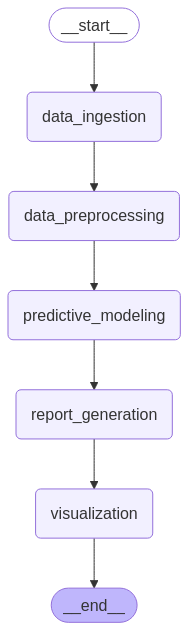

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# Execution
def run_financial_analysis():
    financial_workflow = build_financial_analysis_workflow()
    initial_state = {
        'raw_data': [],
        'processed_data': None,
        'predictions': [],
        'analysis_report': '',
        'visualization_paths': [],
        'analyst_feedback': ''
    }
    
    result = financial_workflow.invoke(initial_state)
    print("Financial Analysis Report:")
    print(result['analysis_report'])
    print("\nVisualization Paths:", result['visualization_paths'])

# Main execution
if __name__ == "__main__":
    run_financial_analysis()

Financial Analysis Report:
Based on the provided market predictions, here's a comprehensive investment insight:

**Overall Market Sentiment:**
The overall market sentiment appears to be neutral to slightly bearish. The 5-day forecasts for all three stocks (AAPL, GOOGL, and MSFT) are within a relatively narrow range, indicating a lack of strong momentum in either direction. The confidence intervals are also relatively narrow, suggesting that the predictions are relatively confident.

**Potential Investment Strategies:**
Based on the predictions, here are some potential investment strategies:

1. **Conservative approach:** For investors seeking a more conservative approach, they could consider a "wait-and-see" strategy, waiting for the actual prices to converge with the predicted ranges. This approach minimizes risk and allows investors to reassess the market before making a move.
2. **Range trading:** Given the narrow confidence intervals, investors could consider range trading within t